## A work in progress!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
import theano.tensor as tt

In [4]:
np.random.seed(42)
ydeg = 15
power = np.array([0.002 * np.exp(-l / 5.0) for l in range(1, ydeg + 1) for m in range(-l, l + 1)])
y = np.random.randn((ydeg + 1) ** 2 - 1) * np.sqrt(power)

# True values
truths = {
    "inc":      75.0,
    "u":        [0.4, 0.26],
    "period":   8.53,
    "y":        y,
    "flux_err": 0.001
}

# Generate a synthetic dataset
t = np.arange(0, 27, 1./(24 * 30))
udeg = len(truths["u"])
map = starry.Map(ydeg=ydeg, udeg=udeg)
map[1:, :] = truths["y"]
map[1:] = truths["u"]
map.inc = truths["inc"]
theta = 360. * t / truths["period"]

# Compute the design matrix and dot `y` in to get the flux
X = map.linear_op(theta=theta)
truths["flux"] = (X[:, 0] + tt.dot(X[:, 1:], y)).eval()

# Add noise
flux = truths["flux"] + truths["flux_err"] * np.random.randn(len(t))

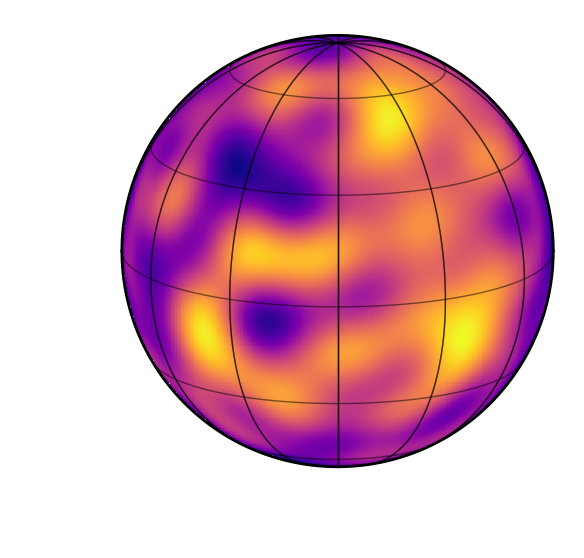

In [5]:
map.show()

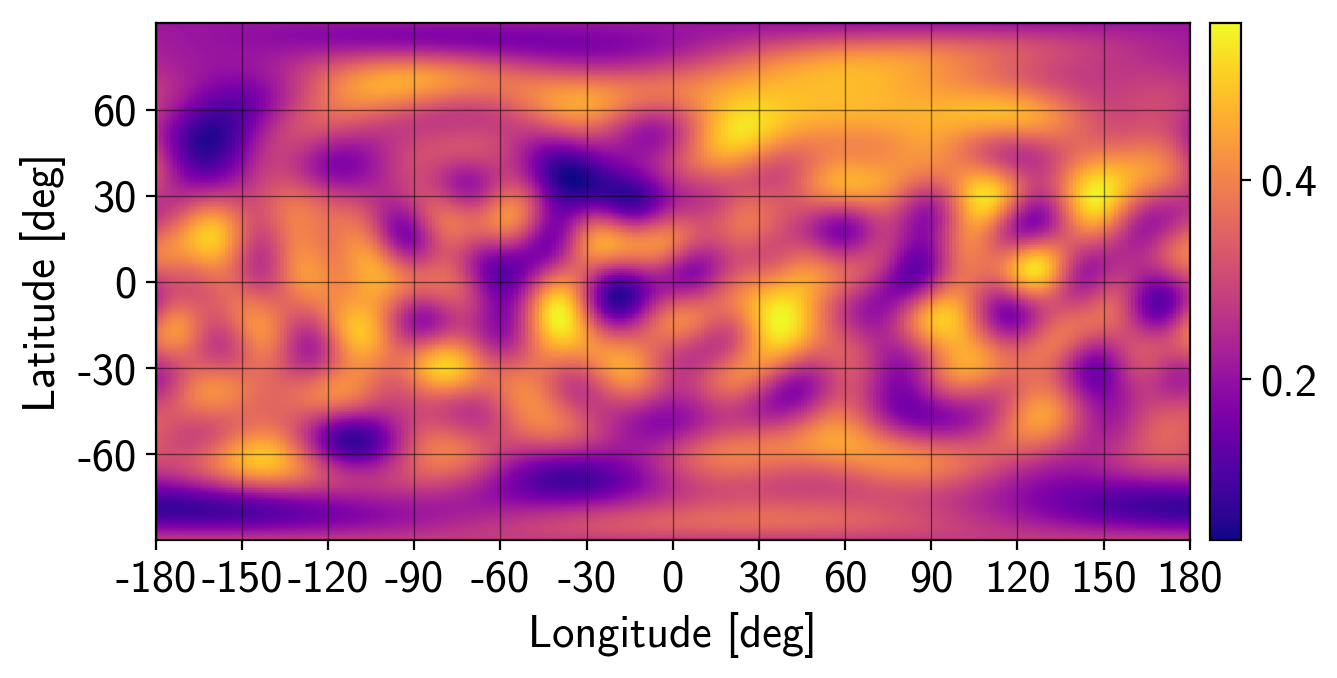

In [6]:
map.show(projection="rect")

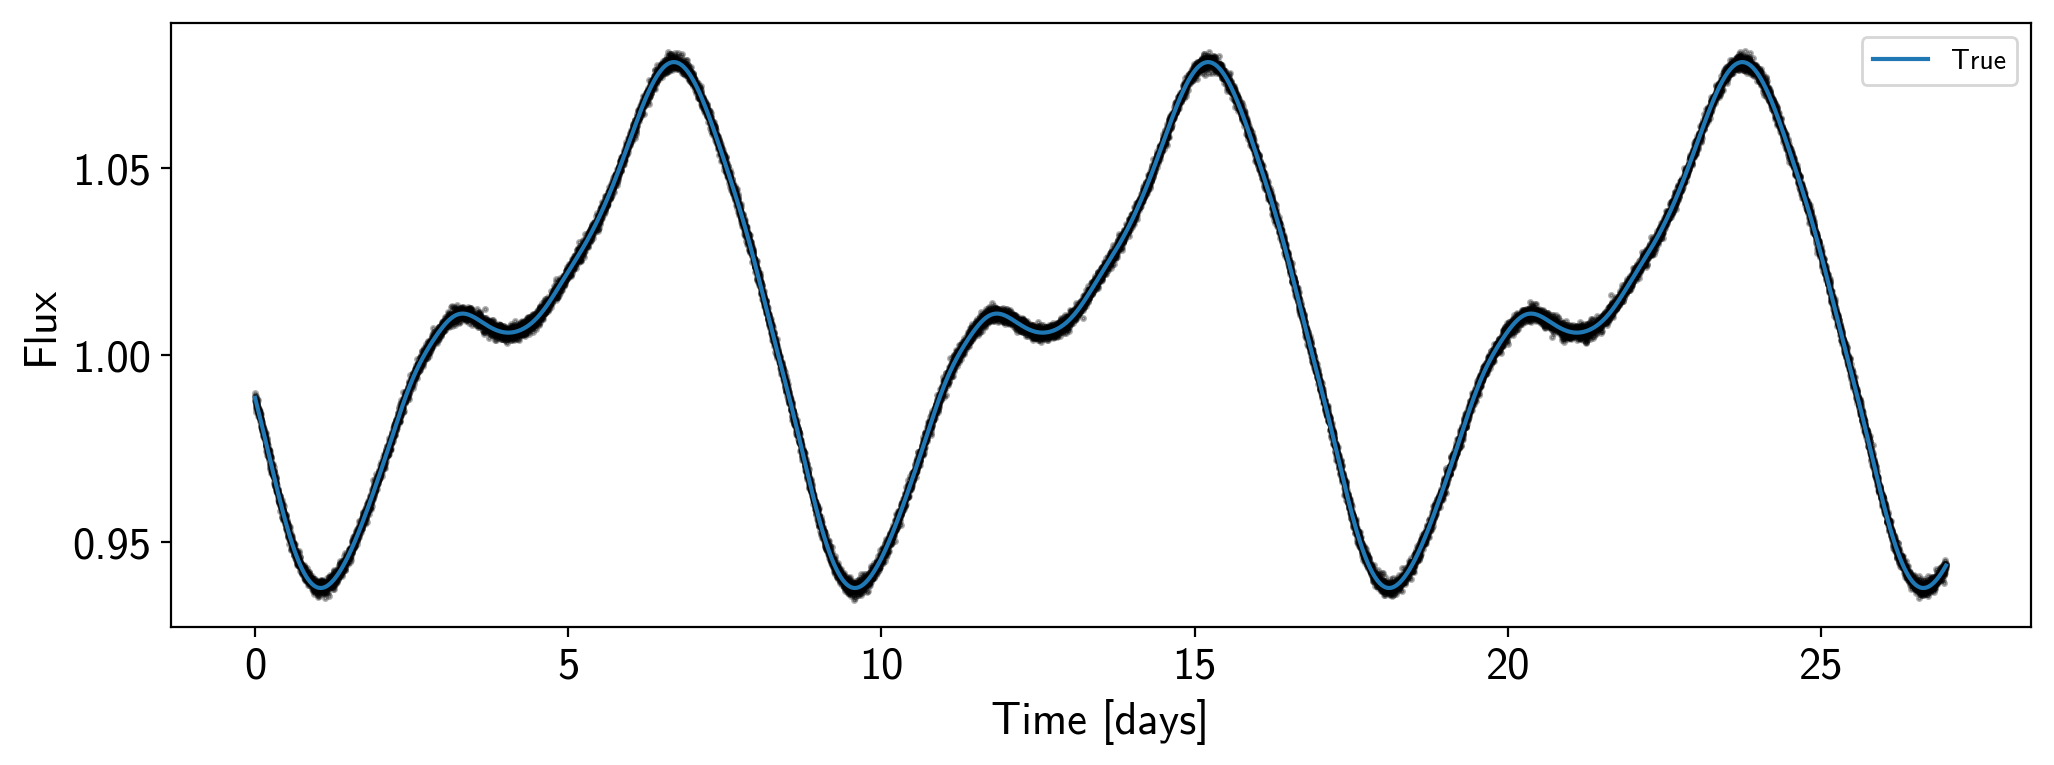

In [7]:
# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

In [8]:
# Define our model
map = starry.Map(ydeg=ydeg, udeg=udeg)
with pm.Model() as model:

    # Priors on the things we're solving for
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    period = pm.Normal("period", 8.5, 0.1)
    inc = pm.Uniform("inc", 60, 90)
    y = pm.MvNormal("y", 0.0, np.diag(power), shape=(255,))
     
    # Compute the model light curve using starry
    theta = 360.0 * t / period
    X = map.linear_op(theta=theta, u=u, inc=inc)
    flux_model = X[:, 0] + tt.dot(X[:, 1:], y)

    # Here we track the value of the model light curve for plotting later
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=truths["flux_err"], observed=flux)

    # Fit for the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

success: False
initial logp: -17335230.884716004
final logp: 92030.52546553356


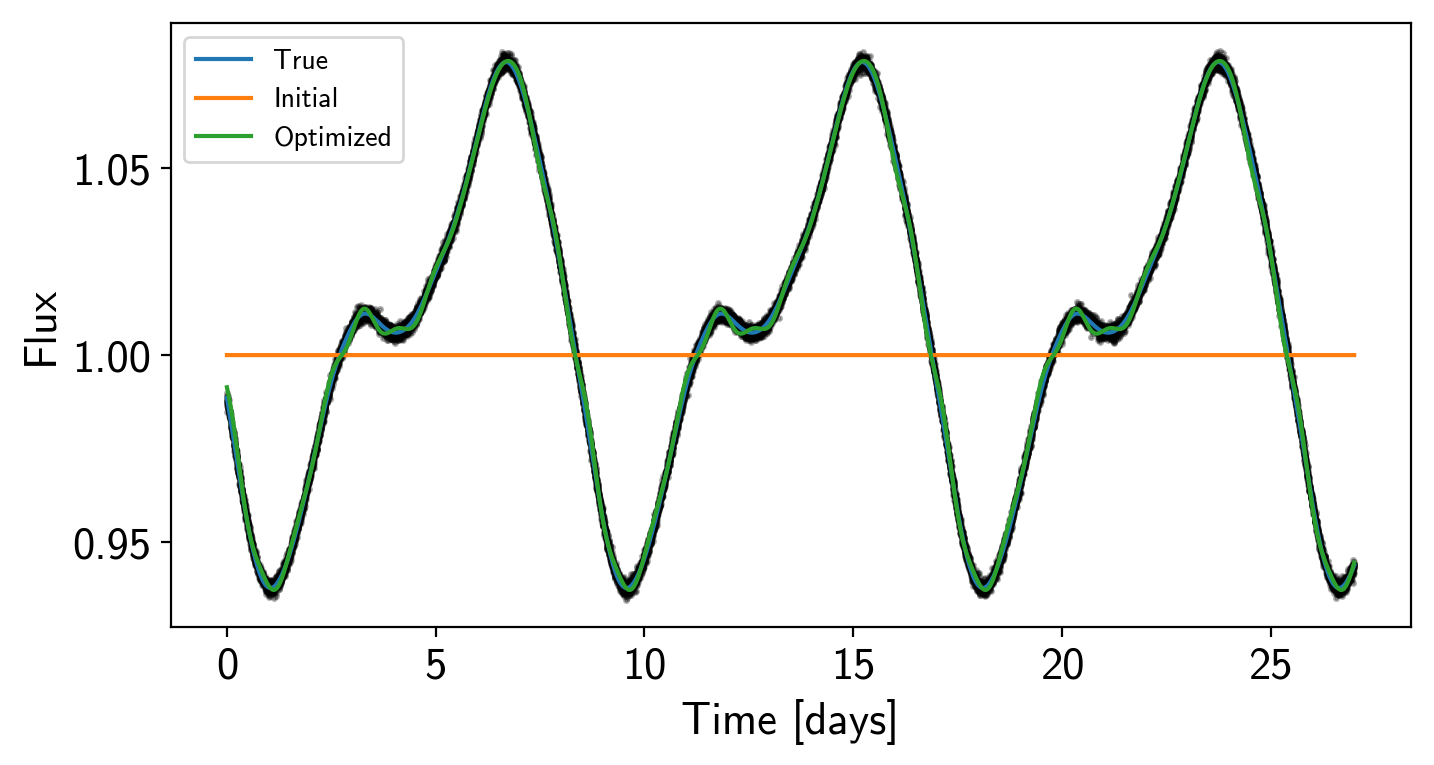

In [9]:
# Plot it
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.plot(t, model_guess, label="Initial")
ax.plot(t, map_soln["flux_model"], label="Optimized")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

In [10]:
# Sample it
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

KeyboardInterrupt: 

In [ ]:
varnames = ["period", "inc", "u"]
pm.summary(trace, varnames=varnames)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);